In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
import matplotlib.pyplot as plt

In [2]:

print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [4]:
def categorize(value):
    if 0 <= value <= 100:
        return 0
    elif 101 <= value <= 200:
        return 1
    else:
        return 2

def add_categories():
    file_path = '../output/training_data/train.csv'
    df = pd.read_csv(file_path)
    # Apply the categorize function to the numerical column and create a new column
    df['Category'] = df['num_triangles'].apply(categorize)

    # Save the DataFrame with the new column back to a CSV file
    df.to_csv('../output_file.csv', index=False)

In [11]:
def remove_white_images_without_neigbour(row):
    if (row['neighbours'] == 0) & (int(row['len_of_boundry_inv']) == 0):
        return False
    else:
        return True
    
def remove_white_images(row):
    if (int(row['len_of_boundry_inv']) == 0):
        return False
    else:
        return True

In [6]:
# Load your CSV file containing image names, features, and labels
data = pd.read_csv('../output/training_data/train.csv')

In [7]:
data.head()

,name,len_of_boundry,len_of_boundry_inv,disjoint_image,tile_size,num_triangles,image_category,triangle_per_100px,density_category,neighbours,len_of_boundry_per_100px
0,branch_line_coupler_0_250_0_0.png,996.0,0.0,0,250,7,0,1.12,0,0,0.0
1,branch_line_coupler_0_250_0_1.png,996.0,0.0,0,250,58,0,9.28,0,2,0.0
2,branch_line_coupler_0_250_0_2.png,1050.0,938.0,1,250,235,2,37.60,1,2,375.2
3,branch_line_coupler_0_250_0_3.png,996.0,0.0,0,250,51,0,8.16,0,4,0.0
4,branch_line_coupler_0_250_0_4.png,996.0,0.0,0,250,14,0,2.24,0,4,0.0


In [8]:
data[data['len_of_boundry_per_100px'] == 0]

,name,len_of_boundry,len_of_boundry_inv,disjoint_image,tile_size,num_triangles,image_category,triangle_per_100px,density_category,neighbours,len_of_boundry_per_100px
0,branch_line_coupler_0_250_0_0.png,996.0,0.0,0,250,7,0,1.12,0,0,0.0
1,branch_line_coupler_0_250_0_1.png,996.0,0.0,0,250,58,0,9.28,0,2,0.0
3,branch_line_coupler_0_250_0_3.png,996.0,0.0,0,250,51,0,8.16,0,4,0.0
4,branch_line_coupler_0_250_0_4.png,996.0,0.0,0,250,14,0,2.24,0,4,0.0
7,branch_line_coupler_0_250_0_7.png,996.0,0.0,0,250,13,0,2.08,0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6247,planar_filter_95_250_4_1.png,996.0,0.0,0,250,77,0,12.32,0,4,0.0
6261,planar_filter_95_250_6_1.png,996.0,0.0,0,250,3,0,0.48,0,2,0.0
6262,planar_filter_95_250_6_2.png,996.0,0.0,0,250,3,0,0.48,0,4,0.0
6266,planar_filter_95_250_6_6.png,996.0,0.0,0,250,8,0,1.28,0,4,0.0


In [ ]:
data['Category'] = data['num_triangles'].apply(categorize)
data.head()

In [9]:
data.shape

(6274, 11)

In [12]:
data = data[data.apply(remove_white_images, axis=1)]
data.shape

(4693, 11)

In [13]:
# Load and preprocess black and white images
image_data = []
for image_file in data['name']:
    image = load_img('../output/tiles/' + image_file, color_mode='grayscale', target_size=(224, 224))
    image = img_to_array(image)
    image /= 255.0  # Normalize pixel values
    image_data.append(image)

image_data = np.array(image_data)

In [14]:
# Load numerical features and one-hot encode labels
#features = data[['len_of_boundry_inv', 'disjoint_image']].values
features = data[['len_of_boundry_per_100px', 'disjoint_image', 'neighbours']].values
labels = data['density_category'].values

# One-hot encode labels
labels = to_categorical(labels)


In [15]:
num_classes = len(set(data['image_category'].values))
print(labels.shape)

(4693, 3)


In [16]:
noc = features.shape[1]

In [19]:
df = pd.DataFrame(labels)

# Check which columns have all zero values
all_zero_columns = df.columns[(df == 0).all()]
df = df.drop(all_zero_columns, axis=1)
print(all_zero_columns)

all_zero_after = df.columns[(df == 0).all()]
print(all_zero_after)

Index([], dtype='int64')
Index([], dtype='int64')


In [17]:
from sklearn.preprocessing import RobustScaler

In [18]:
robust_scaler = RobustScaler()
features = robust_scaler.fit_transform(features)

In [19]:
# Split the data into training, validation, and test sets for images
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Split the data into training, validation, and test sets for features
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)
#features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

In [34]:
def printshape(val):
    for v in val:
        print(v.shape)

In [35]:
printshape([X_train, X_test, X_val])
printshape([y_train, y_test, y_val])
printshape([features_train, features_test, features_val])
printshape([labels_train, labels_test, labels_val])

NameError: name 'X_val' is not defined

In [36]:
# Define the input layers
image_input = Input(shape=(224, 224, 1))
feature_input = Input(shape=(2,))

In [20]:
def create_model():
    # Define the input layers
    image_input = Input(shape=(224, 224, 1))
    feature_input = Input(shape=(noc,))

    # CNN for processing images
    conv1 = Conv2D(16, (3, 3), activation='relu')(image_input)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, (3, 3), activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten = Flatten()(maxpool2)

    # Dense network for processing features
    dense1 = Dense(16, activation='relu')(feature_input)

    # Combine the two networks
    merged = Concatenate()([flatten, dense1])

    # Fully connected layers
    fc1 = Dense(32, activation='relu')(merged)
    output = Dense(3, activation='softmax')(fc1)

    # Create the model
    model = keras.Model(inputs=[image_input, feature_input], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [22]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 222, 222, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 111, 111, 16  0          ['conv2d_2[0][0]']               
                                )                                                           

In [23]:
from keras.utils import plot_model, model_to_dot

# Assuming 'model' is your neural network model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Assuming 'model' is your neural network model
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Save the DOT file
with open("functional_model.dot", "w") as dot_file:
    dot_file.write(dot.to_string())

## Cross Entropy

In [14]:
from sklearn.model_selection import StratifiedKFold, KFold

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
accuracy = []
model_history = []
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    features_train_fold, features_val_fold = features_train[train_index], features_train[test_index]
    labels_train_fold, labels_val_fold = labels_train[train_index], labels_train[test_index]

    # Create and compile your CNN model
    model = create_model()

    # Train the model on the current fold
    history = model.fit([X_train_fold, features_train_fold], y_train_fold, epochs=10, batch_size=32, validation_data=([X_val_fold, features_val_fold], y_val_fold))
    #model.fit([X_train, features_train], y_train, validation_data=([X_val, features_val], y_val), epochs=20)

    # Evaluate the model on the test set of the current fold
    test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
    print(f'Test accuracy for current fold: {test_accuracy}')
    accuracy.append(test_accuracy)
    model_history.append(history)

Epoch 1/10
94/94 [==============================] - 6s 20ms/step - loss: 1.7705 - accuracy: 0.5624 - val_loss: 1.0660 - val_accuracy: 0.5979
Epoch 2/10
94/94 [==============================] - 1s 16ms/step - loss: 1.0509 - accuracy: 0.5867 - val_loss: 1.0335 - val_accuracy: 0.6005
Epoch 3/10
94/94 [==============================] - 1s 15ms/step - loss: 1.0228 - accuracy: 0.5904 - val_loss: 1.0086 - val_accuracy: 0.6019
Epoch 4/10
94/94 [==============================] - 1s 15ms/step - loss: 0.9976 - accuracy: 0.5934 - val_loss: 0.9928 - val_accuracy: 0.5952
Epoch 5/10
94/94 [==============================] - 1s 15ms/step - loss: 0.9818 - accuracy: 0.5961 - val_loss: 0.9742 - val_accuracy: 0.6019
Epoch 6/10
94/94 [==============================] - 1s 15ms/step - loss: 0.9693 - accuracy: 0.5957 - val_loss: 0.9700 - val_accuracy: 0.6072
Epoch 7/10
94/94 [==============================] - 1s 15ms/step - loss: 0.9589 - accuracy: 0.5984 - val_loss: 0.9570 - val_accuracy: 0.5992
Epoch 8/10
94

In [17]:
print(accuracy)
print(np.average(accuracy))

[0.6091586947441101, 0.6474973559379578, 0.7018104195594788, 0.6943557262420654, 0.7135249972343445]
0.6732694387435914


In [18]:
def showDetails(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

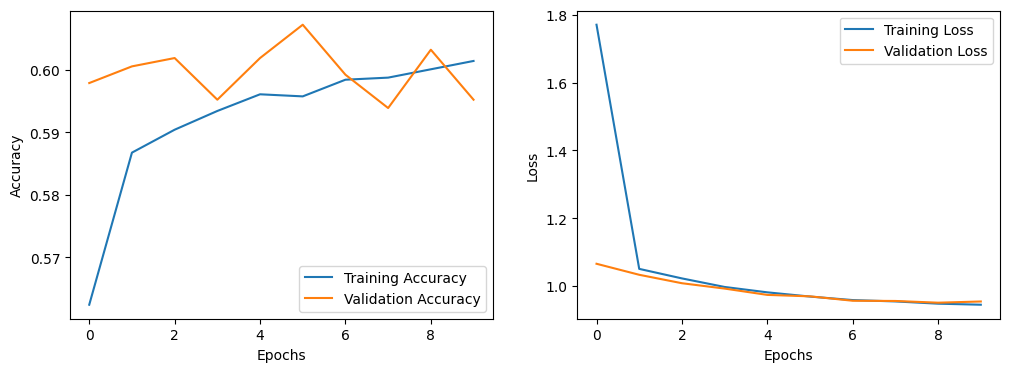

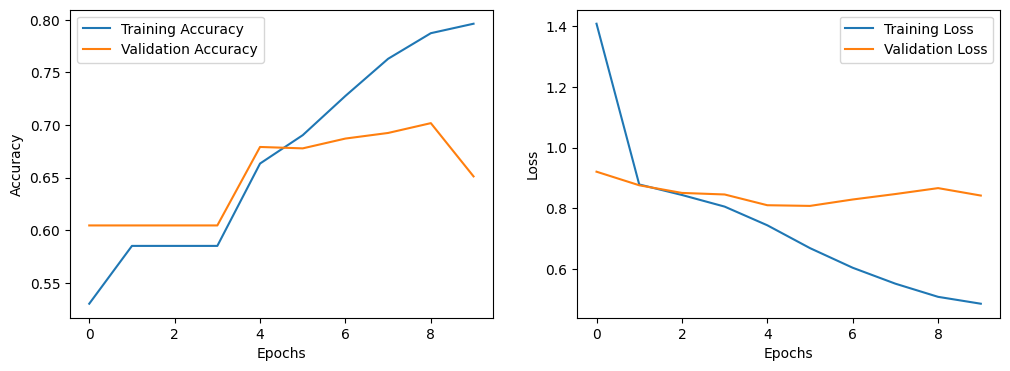

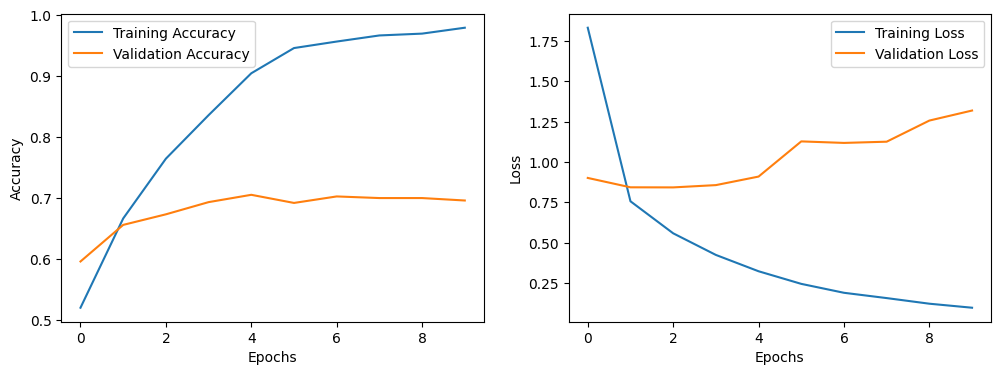

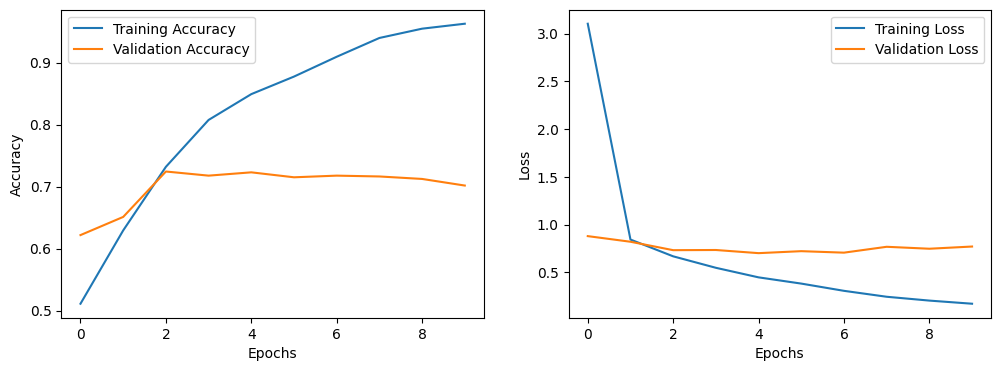

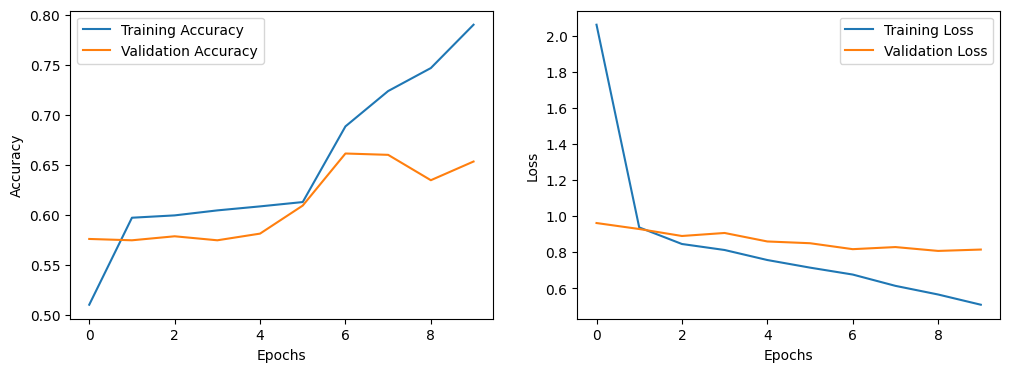

In [19]:
for history in model_history:
    showDetails(history)

## Hyper parameter tuning

In [18]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dropout, BatchNormalization

In [19]:
def create_model_tuning(learning_rate = 0.001, num_layers=1, num_filters = 16):
    # Define the input layers
    #image_input, feature_input = inputs
    image_input = Input(shape=(224, 224, 1))
    feature_input = Input(shape=(noc,))

    # CNN for processing images
    # conv1 = Conv2D(16, (3, 3), activation='relu')(image_input)
    # maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # conv2 = Conv2D(16, (3, 3), activation='relu')(maxpool1)
    # maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # flatten = Flatten()(maxpool1)

    x = image_input
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu')(x)
        #x = BatchNormalization()(x)
        #x = Dropout(0.4)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    flatten = Flatten()(x)

    # Dense network for processing features
    dense1 = Dense(num_filters, activation='relu')(feature_input)

    # Combine the two networks
    merged = Concatenate()([flatten, dense1])

    # Fully connected layers
    fc1 = Dense(32, activation='relu')(merged)
    output = Dense(3, activation='softmax')(fc1)

    # Create the model
    model = keras.Model(inputs=[image_input, feature_input], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [20]:
# Wrapper function for multiple inputs
def create_cnn_model_wrapper(learning_rate=0.001, num_layers=3, num_filters=64):
    # Assuming you have a function that creates your CNN model with multiple inputs
    model = create_model_tuning(learning_rate=learning_rate, num_layers=num_layers, num_filters=num_filters)
    return model

In [ ]:
model = create_model_tuning()
model.summary()

In [111]:
cnn_model = KerasClassifier(build_fn=create_model_tuning, epochs=10, batch_size=32, verbose=0)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_layers': [1, 2, 3],
    'num_filters': [16, 32, 48]
}

#grid = GridSearchCV(estimator=cnn_model, param_grid=param_grid, cv=5, scoring='accuracy')
random_search = RandomizedSearchCV(estimator=cnn_model, param_distributions=param_grid, n_iter=10, cv=5)

In [99]:
print('X_train : ', X_train.shape)
print('features_train : ', features_train.shape)
print('y_train : ', y_train.shape)

X_train :  (4899, 224, 224, 1)
features_train :  (4899, 3)
y_train :  (4899, 3)


In [ ]:
#combined_X_train = np.stack([X_train, features_train], axis=-1)
#grid_result = grid.fit(combined_X_train, y_train)
grid_result = grid.fit([X_train, features_train], y_train)

In [ ]:
random_search_result = random_search.fit([X_train, features_train], y_train)

## Optuna

In [22]:
def create_model_optuna(trial, noc, learning_rate, num_filters, num_layers):

    # Define the input layers
    #image_input, feature_input = inputs
    image_input = Input(shape=(224, 224, 1))
    feature_input = Input(shape=(noc,))


    x = image_input
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu')(x)
        #x = BatchNormalization()(x)
        #x = Dropout(0.4)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    flatten = Flatten()(x)

    # Dense network for processing features
    dense1 = Dense(num_filters, activation='relu')(feature_input)

    # Combine the two networks
    merged = Concatenate()([flatten, dense1])

    # Fully connected layers
    fc1 = Dense(32, activation='relu')(merged)
    output = Dense(3, activation='softmax')(fc1)

    # Create the model
    model = keras.Model(inputs=[image_input, feature_input], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [23]:
import optuna
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam

In [24]:
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif name == 'sgd':
        return SGD(learning_rate=learning_rate)
    elif name == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif name == 'adagrad':
        return Adagrad(learning_rate=learning_rate)
    elif name == 'adadelta':
        return Adadelta(learning_rate=learning_rate)
    elif name == 'adamax':
        return Adamax(learning_rate=learning_rate)
    elif name == 'nadam':
        return Nadam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

In [25]:
def objective(trial):
    image_shape = (224, 224, 1)  # Adjust based on your image dimensions
    noc = 3  # Number of features

    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    num_filters = trial.suggest_categorical('num_filters', [16, 32])
    num_layers = trial.suggest_int('num_layers', 1, 2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [10, 15, 20])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam'])


    model = create_model_optuna(trial, noc, learning_rate, num_filters, num_layers)

    optimizer = get_optimizer(optimizer_name, learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Split the data into training and validation sets
    X_train, X_val, features_train, features_val, y_train, y_val = train_test_split(
        image_data, features, labels, test_size=0.2, random_state=0
    )

    # Train the model
    history = model.fit(
        [X_train, features_train], y_train,
        validation_data=([X_val, features_val], y_val),
        epochs=epochs, batch_size=batch_size, verbose=0
    )

    # Return the validation accuracy for Optuna to optimize
    return history.history['val_accuracy'][-1]

In [26]:
# with more hyper parameter
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best parameters found by Optuna
print('Best trial:')
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-18 15:34:52,090] A new study created in memory with name: no-name-45971bd7-7d84-41a3-a0cb-18efcf0e3654
[I 2023-12-18 15:35:41,798] Trial 0 finished with value: 0.5271565318107605 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 15, 'optimizer': 'adadelta'}. Best is trial 0 with value: 0.5271565318107605.
[I 2023-12-18 15:36:35,714] Trial 1 finished with value: 0.5772097706794739 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 1, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.5772097706794739.
[I 2023-12-18 15:36:52,386] Trial 2 finished with value: 0.5612353682518005 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 1, 'batch_size': 64, 'epochs': 10, 'optimizer': 'nadam'}. Best is trial 1 with value: 0.5772097706794739.
[I 2023-12-18 15:37:50,921] Trial 3 finished with value: 0.5793397426605225 and parameters: {'learning_rate': 0.01, 

Best trial:
Accuracy: 0.5867944359779358
Best hyperparameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'sgd'}


In [39]:
# with white images
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best parameters found by Optuna
print('Best trial:')
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-11 13:37:35,663] A new study created in memory with name: no-name-fd7337be-1209-4f48-87ce-b4b0ee63b1be
[I 2023-12-11 13:37:59,477] Trial 0 finished with value: 0.7363265156745911 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1}. Best is trial 0 with value: 0.7363265156745911.
[I 2023-12-11 13:38:30,296] Trial 1 finished with value: 0.7477551102638245 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2}. Best is trial 1 with value: 0.7477551102638245.
[I 2023-12-11 13:38:57,265] Trial 2 finished with value: 0.7518367171287537 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 1}. Best is trial 2 with value: 0.7518367171287537.
[I 2023-12-11 13:39:24,606] Trial 3 finished with value: 0.7591836452484131 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 1}. Best is trial 3 with value: 0.7591836452484131.
[I 2023-12-11 13:39:51,684] Trial 4 finished with value: 0.7591836452484131 and 

Best trial:
Accuracy: 0.76816326379776
Best hyperparameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 1}


In [23]:

# without white images
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best parameters found by Optuna
print('Best trial:')
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-11 13:02:16,900] A new study created in memory with name: no-name-bbcc3b3e-8bae-493c-9646-cf2acab3751a
[I 2023-12-11 13:02:33,822] Trial 0 finished with value: 0.7273695468902588 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 1}. Best is trial 0 with value: 0.7273695468902588.
[I 2023-12-11 13:02:54,236] Trial 1 finished with value: 0.7028753757476807 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 2}. Best is trial 0 with value: 0.7273695468902588.
[I 2023-12-11 13:03:18,361] Trial 2 finished with value: 0.690095841884613 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 2}. Best is trial 0 with value: 0.7273695468902588.
[I 2023-12-11 13:03:35,968] Trial 3 finished with value: 0.7188498377799988 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1}. Best is trial 0 with value: 0.7273695468902588.
[I 2023-12-11 13:03:59,827] Trial 4 finished with value: 0.6624068021774292 and par

Best trial:
Accuracy: -0.7454739212989807
Best hyperparameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1}


In [125]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [59]:
model = create_model()

In [ ]:
model.summary()

In [60]:
# Train the model
history = model.fit([X_train, features_train], y_train, validation_data=([X_val, features_val], y_val), epochs=20)

Epoch 1/20
78/78 [==============================] - 3s 25ms/step - loss: 4.9668 - accuracy: 0.4876 - val_loss: 1.2176 - val_accuracy: 0.4425
Epoch 2/20
78/78 [==============================] - 2s 19ms/step - loss: 0.8182 - accuracy: 0.6283 - val_loss: 0.9743 - val_accuracy: 0.5851
Epoch 3/20
78/78 [==============================] - 2s 20ms/step - loss: 0.7066 - accuracy: 0.6944 - val_loss: 0.8768 - val_accuracy: 0.6207
Epoch 4/20
78/78 [==============================] - 2s 20ms/step - loss: 0.5905 - accuracy: 0.7426 - val_loss: 0.8608 - val_accuracy: 0.6775
Epoch 5/20
78/78 [==============================] - 2s 19ms/step - loss: 0.4721 - accuracy: 0.8253 - val_loss: 0.8765 - val_accuracy: 0.6499
Epoch 6/20
78/78 [==============================] - 2s 20ms/step - loss: 0.3970 - accuracy: 0.8602 - val_loss: 0.9314 - val_accuracy: 0.6207
Epoch 7/20
78/78 [==============================] - 2s 20ms/step - loss: 0.3391 - accuracy: 0.8877 - val_loss: 0.9559 - val_accuracy: 0.6613
Epoch 8/20
78

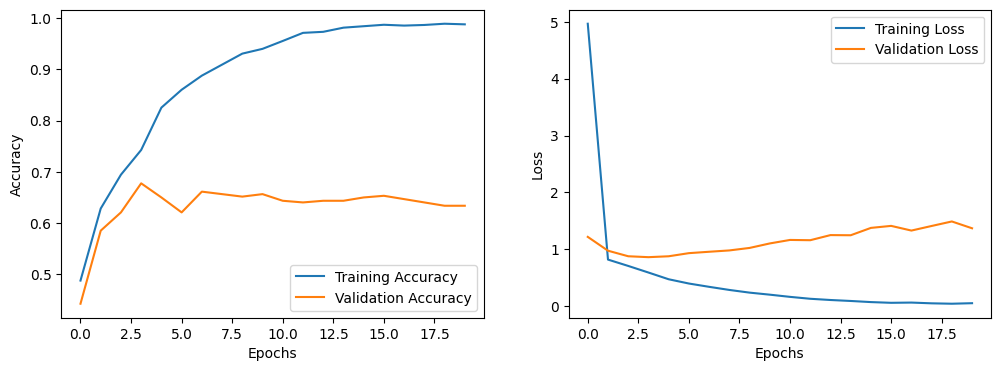

In [61]:
# without neighbouring borders for white images
showDetails(history)

In [24]:
test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
print(f'Test accuracy: {test_accuracy}')


34/34 [==============================] - 0s 10ms/step - loss: 1.5015 - accuracy: 0.6749
Test accuracy: 0.6748582124710083


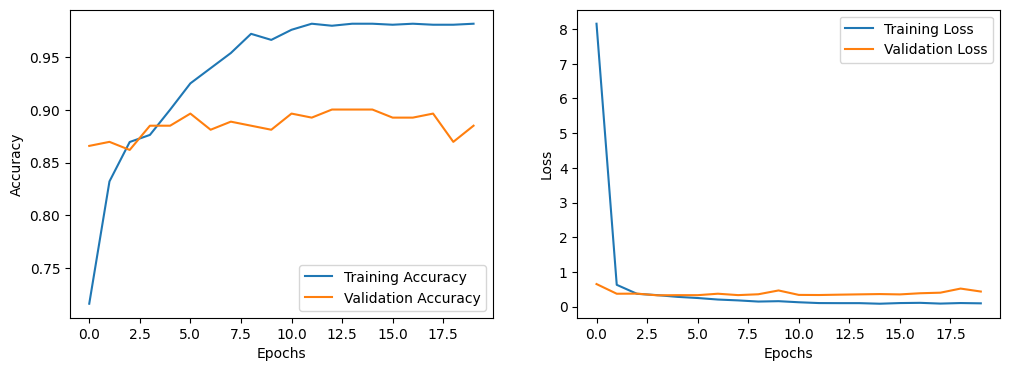

In [73]:
# with neighbouring borders for white images
showDetails(history)

In [74]:
test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
print(f'Test accuracy: {test_accuracy}')

11/11 [==============================] - 0s 9ms/step - loss: 0.5352 - accuracy: 0.8349
Test accuracy: 0.8348624110221863


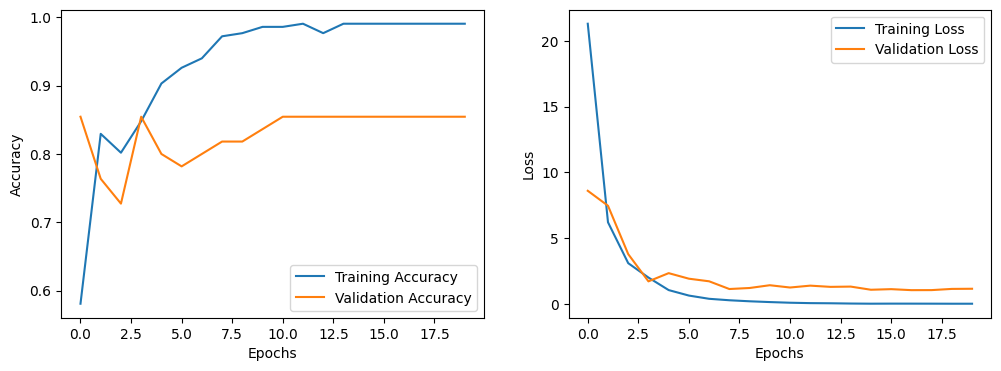

In [61]:
showDetails(history)

In [14]:
from keras.utils import plot_model, model_to_dot

# Assuming 'model' is your neural network model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Assuming 'model' is your neural network model
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Save the DOT file
with open("model.dot", "w") as dot_file:
    dot_file.write(dot.to_string())


In [21]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()